In [1]:
import time
from functools import partial
import jax
import jax.numpy as jnp
import jax.random as jr
import jax.scipy.stats as jss
import numpy as np
import matplotlib.pyplot as plt

from nuts import nuts_sample

plt.set_cmap("coolwarm")

<Figure size 640x480 with 0 Axes>

### Extreme data compression while searching for new physics

Here we define two models; the baseline physics model $M_B$ that is a function of the parameters $\Theta$, and the extended physics model $M_E$ that is a function of the parameters $\Theta$ and $\Gamma$.

The baseline model predicts the surface brightness of a thin exponential disk galaxy seen at an angle

$$
\boldsymbol{\mu}(\Theta) = \boldsymbol{\mu}(r, \varphi; A, a, \epsilon, \phi) = A\exp\bigg[-\frac{ r\sqrt{1 + \epsilon^2 - 2\epsilon\cos 2(\varphi - \phi)} }{ a\sqrt{1 - \epsilon^2} }\bigg],
$$

while the extended model contains a circularly symmetric bulge with a Gaussian projected radial profile parameterised as 

$$
\boldsymbol{\mu}(\Theta, \Gamma) = \boldsymbol{\mu}(\Theta, A_b, a_b) = \boldsymbol{\mu}(\Theta) + A_b\exp(-a_b r^2).
$$

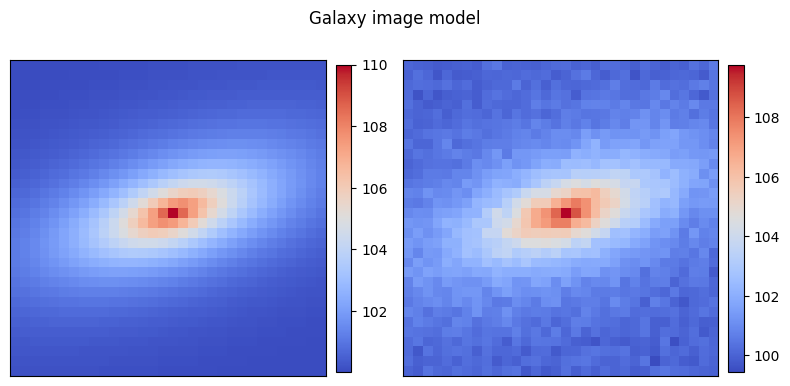

In [2]:
def elliptical_exponential_galaxy(
    key, A, a, epsilon, phi, n_pix=32, noise=False
):
    background_level = 100.

    x0, y0 = n_pix // 2, n_pix // 2

    y, x = jnp.meshgrid(np.arange(n_pix), np.arange(n_pix), indexing='ij')
    dx = x - x0
    dy = y - y0

    # Convert to polar coordinates relative to center
    r = jnp.sqrt(dx ** 2. + dy ** 2.)
    varphi = jnp.arctan2(dy, dx)

    # Compute the elliptical exponential brightness
    numerator = jnp.sqrt(1. + epsilon ** 2. - 2. * epsilon * jnp.cos(2. * (varphi - phi)))
    denominator = a * jnp.sqrt(1. - epsilon ** 2.)
    mu = A * jnp.exp(-r * numerator / denominator) + background_level

    if noise:
        mu += jr.normal(key, mu.shape) * 0.2

    return mu

key = jr.key(int(time.time()))

img_clean = elliptical_exponential_galaxy(
    key, A=10.0, a=5.0, phi=0.3, epsilon=0.4
)
img_noisy = elliptical_exponential_galaxy(
    key, A=10.0, a=5.0, phi=0.3, epsilon=0.4, noise=True
)

# Plot
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
fig.suptitle("Galaxy image model")

ax = axs[0]
im = ax.imshow(img_clean, origin='lower')
plt.colorbar(im, fraction=0.045, pad=0.03)

ax = axs[1]
im = ax.imshow(img_noisy, origin='lower')
plt.colorbar(im, fraction=0.045, pad=0.03)

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

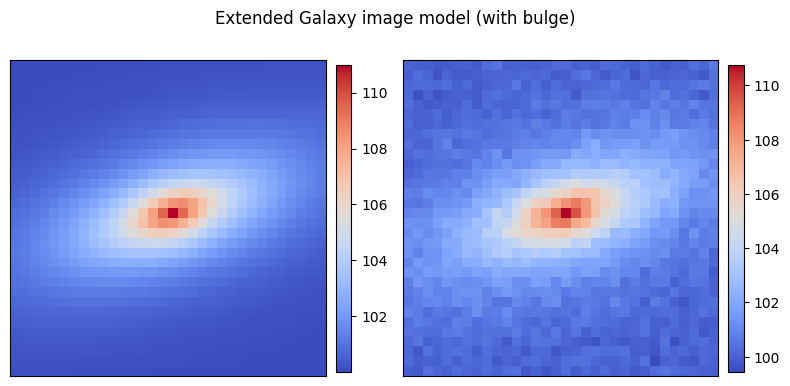

In [3]:
def elliptical_exponential_bulge_galaxy(
    key, A, a, epsilon, phi, A_b, a_b, n_pix=32, noise=False
):
    background_level = 100.

    x0, y0 = n_pix // 2, n_pix // 2

    y, x = jnp.meshgrid(np.arange(n_pix), np.arange(n_pix), indexing='ij')
    dx = x - x0
    dy = y - y0

    # Convert to polar coordinates relative to center
    r = jnp.sqrt(dx ** 2. + dy ** 2.)
    varphi = jnp.arctan2(dy, dx)

    # Compute the elliptical exponential brightness
    numerator = jnp.sqrt(1. + epsilon ** 2. - 2. * epsilon * jnp.cos(2. * (varphi - phi)))
    denominator = a * jnp.sqrt(1. - epsilon ** 2.)
    # mu = A_b * jnp.exp(-a_b * r ** 2.)
    mu = A * jnp.exp(-r * numerator / denominator) + A_b * jnp.exp(-a_b * r ** 2.) + background_level

    if noise:
        mu += jr.normal(key, mu.shape) * 0.2

    return mu

img_clean = elliptical_exponential_bulge_galaxy(
    key, A=10.0, a=5.0, phi=0.3, epsilon=0.4, A_b=1.0, a_b=0.1
)
img_noisy = elliptical_exponential_bulge_galaxy(
    key, A=10.0, a=5.0, phi=0.3, epsilon=0.4, A_b=1.0, a_b=0.1, noise=True
)

# Plot
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
fig.suptitle("Extended Galaxy image model (with bulge)")

ax = axs[0]
im = ax.imshow(img_clean, origin='lower')
plt.colorbar(im, fraction=0.045, pad=0.03)

ax = axs[1]
im = ax.imshow(img_noisy, origin='lower')
plt.colorbar(im, fraction=0.045, pad=0.03)

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

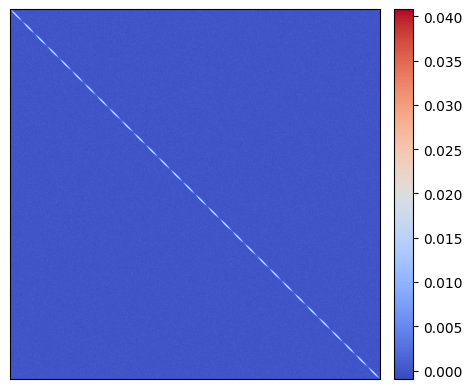

In [ ]:
# Simulator function for mean, covariance and derivatives
n_pix = 20
n_d = n_pix ** 2
n_s = 40_000

parameter_strings = [r"$A$", r"$a$", r"$\epsilon$", r"$\phi$"]
theta = jnp.array([100.0, 0.25 * n_pix, 0.5, 0.4])

parameter_strings_extended = [r"$A_b$", r"$a_b$"]
gamma = jnp.array([0.3 * theta[0], 1. / 2 * jnp.square(theta[1])])

theta_gamma = jnp.concatenate([theta, gamma])

n_theta = theta.size
n_gamma = 5 # Number of additional extended MOPED filters

def _simulator(key, A, a, epsilon, phi):
    galaxy_image = elliptical_exponential_galaxy(
        key, 
        A=A, 
        a=a, 
        epsilon=epsilon, 
        phi=phi, 
        n_pix=n_pix, 
        noise=True
    )
    return galaxy_image.flatten()

def _simulator_extended(key, A, a, epsilon, phi, A_b, a_b):
    galaxy_image = elliptical_exponential_bulge_galaxy(
        key, 
        A=A, 
        a=a, 
        epsilon=epsilon, 
        phi=phi, 
        A_b=A_b, 
        a_b=a_b, 
        n_pix=n_pix, 
        noise=True
    )
    return galaxy_image.flatten()

@jax.jit
def simulator(key, params=theta):
    A, a, epsilon, phi = params
    return _simulator(key, A=A, a=a, epsilon=epsilon, phi=phi)    

@jax.jit
def simulator_extended(key, params=theta_gamma):
    A, a, epsilon, phi, A_b, a_b = params
    return _simulator_extended(key, A=A, a=a, epsilon=epsilon, phi=phi, A_b=A_b, a_b=a_b)    

def baseline_model(theta):
    A, a, epsilon, phi = theta 
    mu_theta = elliptical_exponential_galaxy(
        key=None, A=A, a=a, epsilon=epsilon, phi=phi, n_pix=n_pix, noise=False
    ).flatten()
    return mu_theta

keys = jr.split(key, n_s)
D_0 = jax.vmap(simulator)(keys)

covariance = jnp.cov(D_0, rowvar=False)
mu = jnp.mean(D_0, axis=0)

# Calculate derivatives
dmus = jax.vmap(jax.jacfwd(simulator, argnums=1), in_axes=(0, None))(keys, theta)
dmu = jnp.mean(dmus, axis=0).T

plt.figure()
im = plt.imshow(covariance)
plt.colorbar(fraction=0.05, pad=0.03)
plt.xticks([])
plt.yticks([])
plt.show()

#### MOPED compression 
Construct a compression from $N$ to $M$ dimensions with
$$
y_\alpha = \mathbf{b}_\alpha^T\mathbf{x}, \; \alpha = [1, M],
$$
where
$$
\mathbf{b}_1 = \frac{C^{-1}\boldsymbol{\mu}_{,1}}{\sqrt{\boldsymbol{\mu}_{,1}^TC^{-1}\boldsymbol{\mu}_{,1}}}, \; \;
\mathbf{b}_{\alpha > 1} = \frac{C^{-1}\boldsymbol{\mu}_{,\alpha} - \sum_{\beta=1}^{\alpha-1}(\boldsymbol{\mu}^T_{,\alpha}\mathbf{b}_\beta)\mathbf{b}_\beta}{\sqrt{\boldsymbol{\mu}_{,\alpha}^TC^{-1}\boldsymbol{\mu}_{,\alpha}} - \sum_{\beta=1}^{\alpha-1}(\boldsymbol{\mu}^T_{,\alpha}\mathbf{b}_\beta)^2}.
$$
A theory $\boldsymbol{\mu}(\Theta)$ is assumed to build the MOPED filters meaning that MOPED statistics cannot be used to compare different theories. This Gram-Schmidt process orthogonalises the modes - ideally with $M\times M$ identity covariance.

Check that the Fisher information is preserved at fiducial model
compressed det F = 2.711641e+21
Full.      det F = 2.7116308e+21


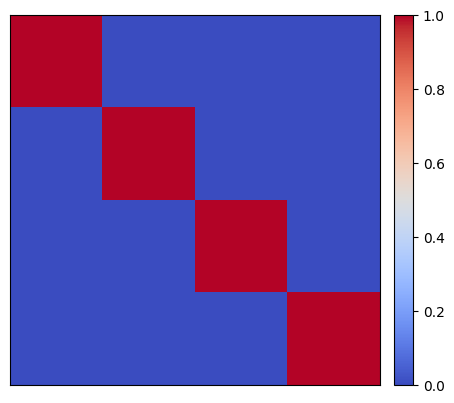

In [5]:
# Compute MOPED filters 
U = np.zeros((n_theta, mu.size))
for p in range(n_theta):
    invcov_deriv = jnp.linalg.solve(covariance, dmu[p, :])
    if p > 0:
        coefs = U[:p, :] @ dmu[p, :]
        U[p, :] = (invcov_deriv - U[:p, :].T @ coefs) / jnp.sqrt(invcov_deriv @ dmu[p, :] - jnp.sum(coefs ** 2.))
    else:
        U[p, :] = invcov_deriv / jnp.sqrt(invcov_deriv @ dmu[p, :])
U = jnp.asarray(U)

# Compression is linear
Y_0 = jnp.matmul(U, D_0.T).T

covariance_y = jnp.cov(Y_0, rowvar=False)

# Confirm that Fisher information is conserved
F_y = np.zeros((n_theta, n_theta))
for i in range(n_theta):
    for j in range(n_theta):
        F_y[i, j] = (U @ dmu[i, :]).T @ jnp.linalg.solve(covariance_y, U @ dmu[j, :])
F_y = jnp.asarray(F_y)
Finv_y = jnp.linalg.inv(F_y)

F_d = np.zeros((n_theta, n_theta))
for i in range(n_theta):
    for j in range(n_theta):
        F_d[i, j] = dmu[i, :].T @ jnp.linalg.solve(covariance, dmu[j, :])
F_d = jnp.asarray(F_d)
Finv_d = jnp.linalg.inv(F_d)

print("Check that the Fisher information is preserved at fiducial model")
print("compressed det F = " + str(jnp.linalg.det(F_y)))
print("Full.      det F = " + str(jnp.linalg.det(F_d)))

# Confirm that covmat is diagonalized 
plt.imshow(covariance_y)
plt.colorbar(fraction=0.05, pad=0.03)
plt.xticks([])
plt.yticks([])
plt.show()

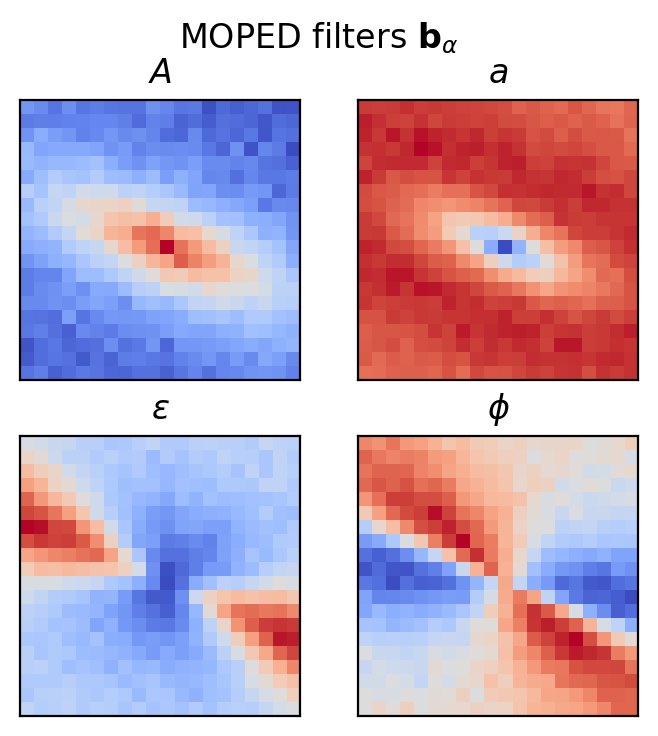

In [6]:
fig, axs = plt.subplots(2, 2, dpi=200, figsize=(4., 4.))
fig.suptitle(r"MOPED filters $\mathbf{b}_\alpha$")
for b, ax, parameter_name in zip(U, axs.ravel(), parameter_strings):
    ax.set_title(parameter_name)
    ax.imshow(b.reshape(n_pix, n_pix))
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

$$
\mathbf{X}=(\mathbf{x}-\boldsymbol{\mu}_F)-\sum_{\alpha=1}^M[\mathbf{b}_\alpha(\mathbf{x}-\boldsymbol{\mu}_F)]C\mathbf{b}_\alpha,
$$

is a vector that points orthogonally out of the baseline model hypersurface at the point $\boldsymbol{\mu}_F$ - it is orthogonal to all the MOPED vectors defined at $\boldsymbol{\mu}_F$ and its covariance is 

$$
C^X_{ij} = C_{ij} - \sum_{\alpha=1}^M(C\mathbf{b}_\alpha)_i(C\mathbf{b}_\alpha)_j.
$$

An 'agnostic extension of the baseline theory' is obtained by defining a set of basis vectors for the $N-M$-dimensional hypersurface at the fiducial point $\boldsymbol{\mu}_F$. Note that the datavector will not lie in this surface due to noise or because the baseline physical model is incorrect.

If the extended modes can be calculated analytically then there is no need to run an $N$-dimensional MCMC. This is done by extending the original baseline model with a linear-order Taylor expansion of the expected signal with additional directions along which the expected datavector can move

$$
\boldsymbol{\mu}(\Theta, \Gamma) = \boldsymbol{\mu}(\Theta) + \sum_{\gamma=M+1}^N\Gamma_\gamma C\mathbf{u}_\gamma,
$$

where $C\mathbf{u}_\gamma$ is the partial derivative of the signal with respect to the new parameter $\Gamma_\gamma$. The new modes $\mathbf{u}_\gamma$ are constructed to be mutually orthogonal but also orthogonal to the original MOPED modes. As many of these extended filters are added as required.

...

The extended filters are

$$
\mathbf{f}_\alpha = 
\begin{cases}
  \mathbf{b}_\alpha & \text{if } 1 \leq \alpha \geq M, \\
  \mathbf{u}_\alpha & \text{if } 1 + M \leq \alpha \geq N.
\end{cases}
$$

and the data points are 
$$
Y_\alpha = \mathbf{f}^T_\alpha(\mathbf{x} - \boldsymbol{\mu}_F),
$$

where the first $M$ datapoints constrain the baseline theory if it is correct, the remaining $N-M$ points can be used to falsify the baseline theory.

(4, 400) (396, 400)


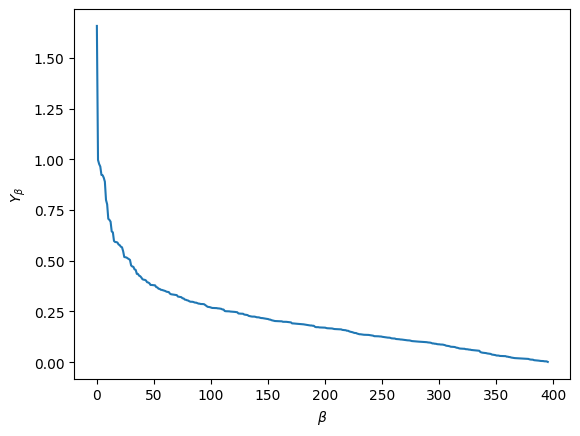

In [7]:
def moped(d):
    return jnp.matmul(U, d)

def get_X(x):
    mu_theta = baseline_model(theta)
    dx = x - mu_theta # Residual from noise or extended physics
    X = dx - sum(moped(dx)[p] * covariance @ U[p, :].T for p in range(n_theta))
    return X

# Measurement simulated with extended physical model
x = simulator_extended(key, theta_gamma) 

# Generate a set of measurements to estimate the covariance of X, even though it is known analytically
keys = jr.split(key, n_s)
x_set = jax.vmap(simulator_extended, in_axes=(0, None))(keys, theta_gamma)
X_set = jax.vmap(get_X)(x_set)
covariance_X = jnp.cov(X_set, rowvar=False)

# Solve eigenvalue problem ensuring orthogonality of MOPED and extended filters
L = jnp.linalg.cholesky(covariance)
Linv = jnp.linalg.inv(L)
A = Linv @ covariance_X @ Linv.T
Lambdas, vs = jnp.linalg.eigh(A) # Columns of vs are eigenvectors
vs = vs.T # Switch eigenvectors "batch" axis to first axis
us = jax.vmap(lambda v_gamma: jnp.linalg.solve(Linv.T, v_gamma))(vs)

# Filter by non-zero eigenvalues
nonzero_eig_mask = jnp.abs(Lambdas) > 1e-5 
Lambdas_nonzero = Lambdas[nonzero_eig_mask] 
us_nonzero = us[nonzero_eig_mask, :] # Same axes as MOPED filters

print(U.shape, us_nonzero.shape)

# Organise extended filters by magnitude of |Y_\beta| for \beta in [M + 1, N]
f_extended = jnp.matmul(us_nonzero, x - baseline_model(theta)) # Only extended filters
eigenvalue_idx_sorted = jnp.argsort(jnp.abs(f_extended))[::-1] # High to low
us_nonzero = us_nonzero[eigenvalue_idx_sorted] # Sort only extended filters (high to low)

plt.figure()
plt.plot(jnp.abs(f_extended)[eigenvalue_idx_sorted])
plt.xlabel(r"$\beta$")
plt.ylabel(r"$Y_\beta$")
plt.show()

U_extended = jnp.concatenate([U, us_nonzero])

MOPED originally doesn't subtract $\mu_F$, am I not subtracting it when I should somewhere?

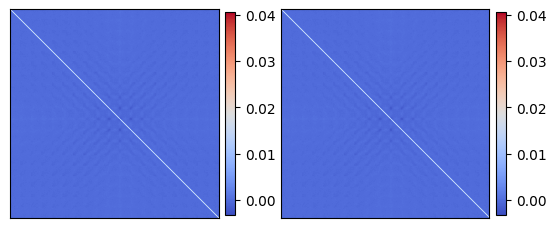

In [8]:
# Calculate analytic covariance of X and compare to simulated
covariance_X_ = np.zeros((n_d, n_d))
for i in range(n_d):
  for j in range(n_d):
    term = sum(
        (covariance @ U[p, :])[i] * (covariance @ U[p, :])[j]
        for p in range(n_theta)
    )
    covariance_X_[i, j] = covariance[i, j] - term

fig, axs = plt.subplots(1, 2)
ax = axs[0]
im = ax.imshow(covariance_X_)
plt.colorbar(im, fraction=0.045, pad=0.03)
ax.set_xticks([])
ax.set_yticks([])
ax = axs[1]
im = ax.imshow(covariance_X)
plt.colorbar(im, fraction=0.045, pad=0.03)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

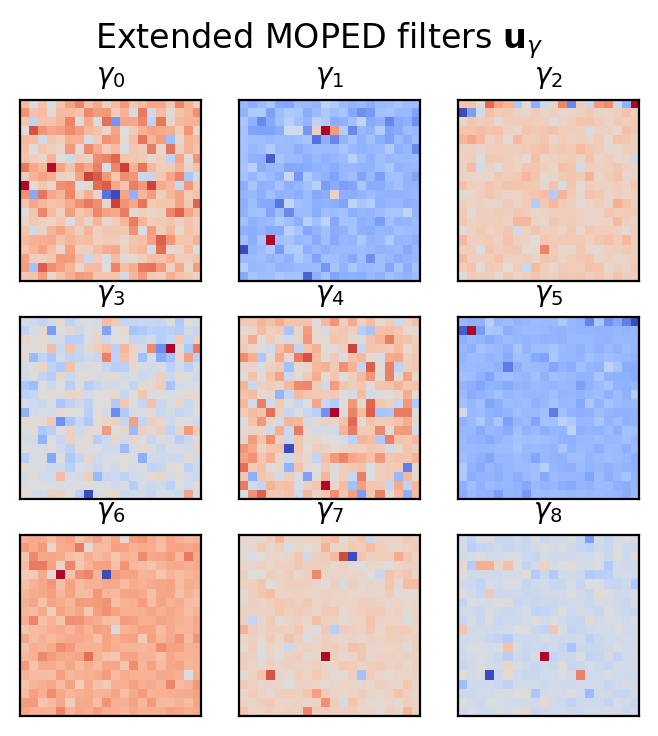

In [9]:
n_side = int(np.sqrt(n_gamma)) + 1

fig, axs = plt.subplots(n_side, n_side, dpi=200, figsize=(4., 4.))
fig.suptitle(r"Extended MOPED filters $\mathbf{u}_\gamma$")

for i, ax in enumerate(axs.ravel()):
    ax.set_title(r"$\gamma_{}$".format(i), fontsize=10)
    ax.imshow(U_extended[n_theta + i, :].reshape(n_pix, n_pix)) # Skip theta filters

for ax in axs.ravel():
    ax.set_xticks([]) 
    ax.set_yticks([])

plt.show()

(40000, 4) (40000, 9)


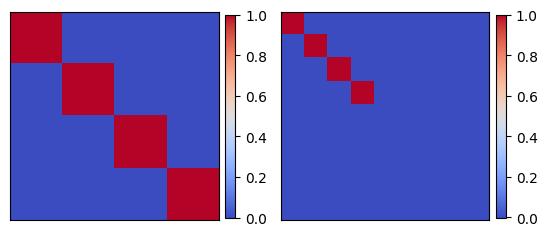

In [10]:
def moped_extended(d, alpha=n_gamma):
    # f_alpha = b_alpha if alpha in 1,...,M OR u_alpha if alpha in [M + 1, N]
    n_modes = min(n_theta + alpha, n_d)
    mu_theta = baseline_model(theta)
    return jnp.matmul(U_extended, d - mu_theta)[:n_modes]

y_moped = jax.vmap(moped)(x_set)
y_moped_extended = jax.vmap(moped_extended)(x_set)

print(y_moped.shape, y_moped_extended.shape)

cov_y_moped = jnp.cov(y_moped, rowvar=False) 
cov_y_moped_extended = jnp.cov(y_moped_extended, rowvar=False)

fig, axs = plt.subplots(1, 2)
ax = axs[0]
im = ax.imshow(cov_y_moped)
plt.colorbar(im, fraction=0.045, pad=0.03)
ax = axs[1]
im = ax.imshow(cov_y_moped_extended)
plt.colorbar(im, fraction=0.045, pad=0.03)
for ax in axs: 
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

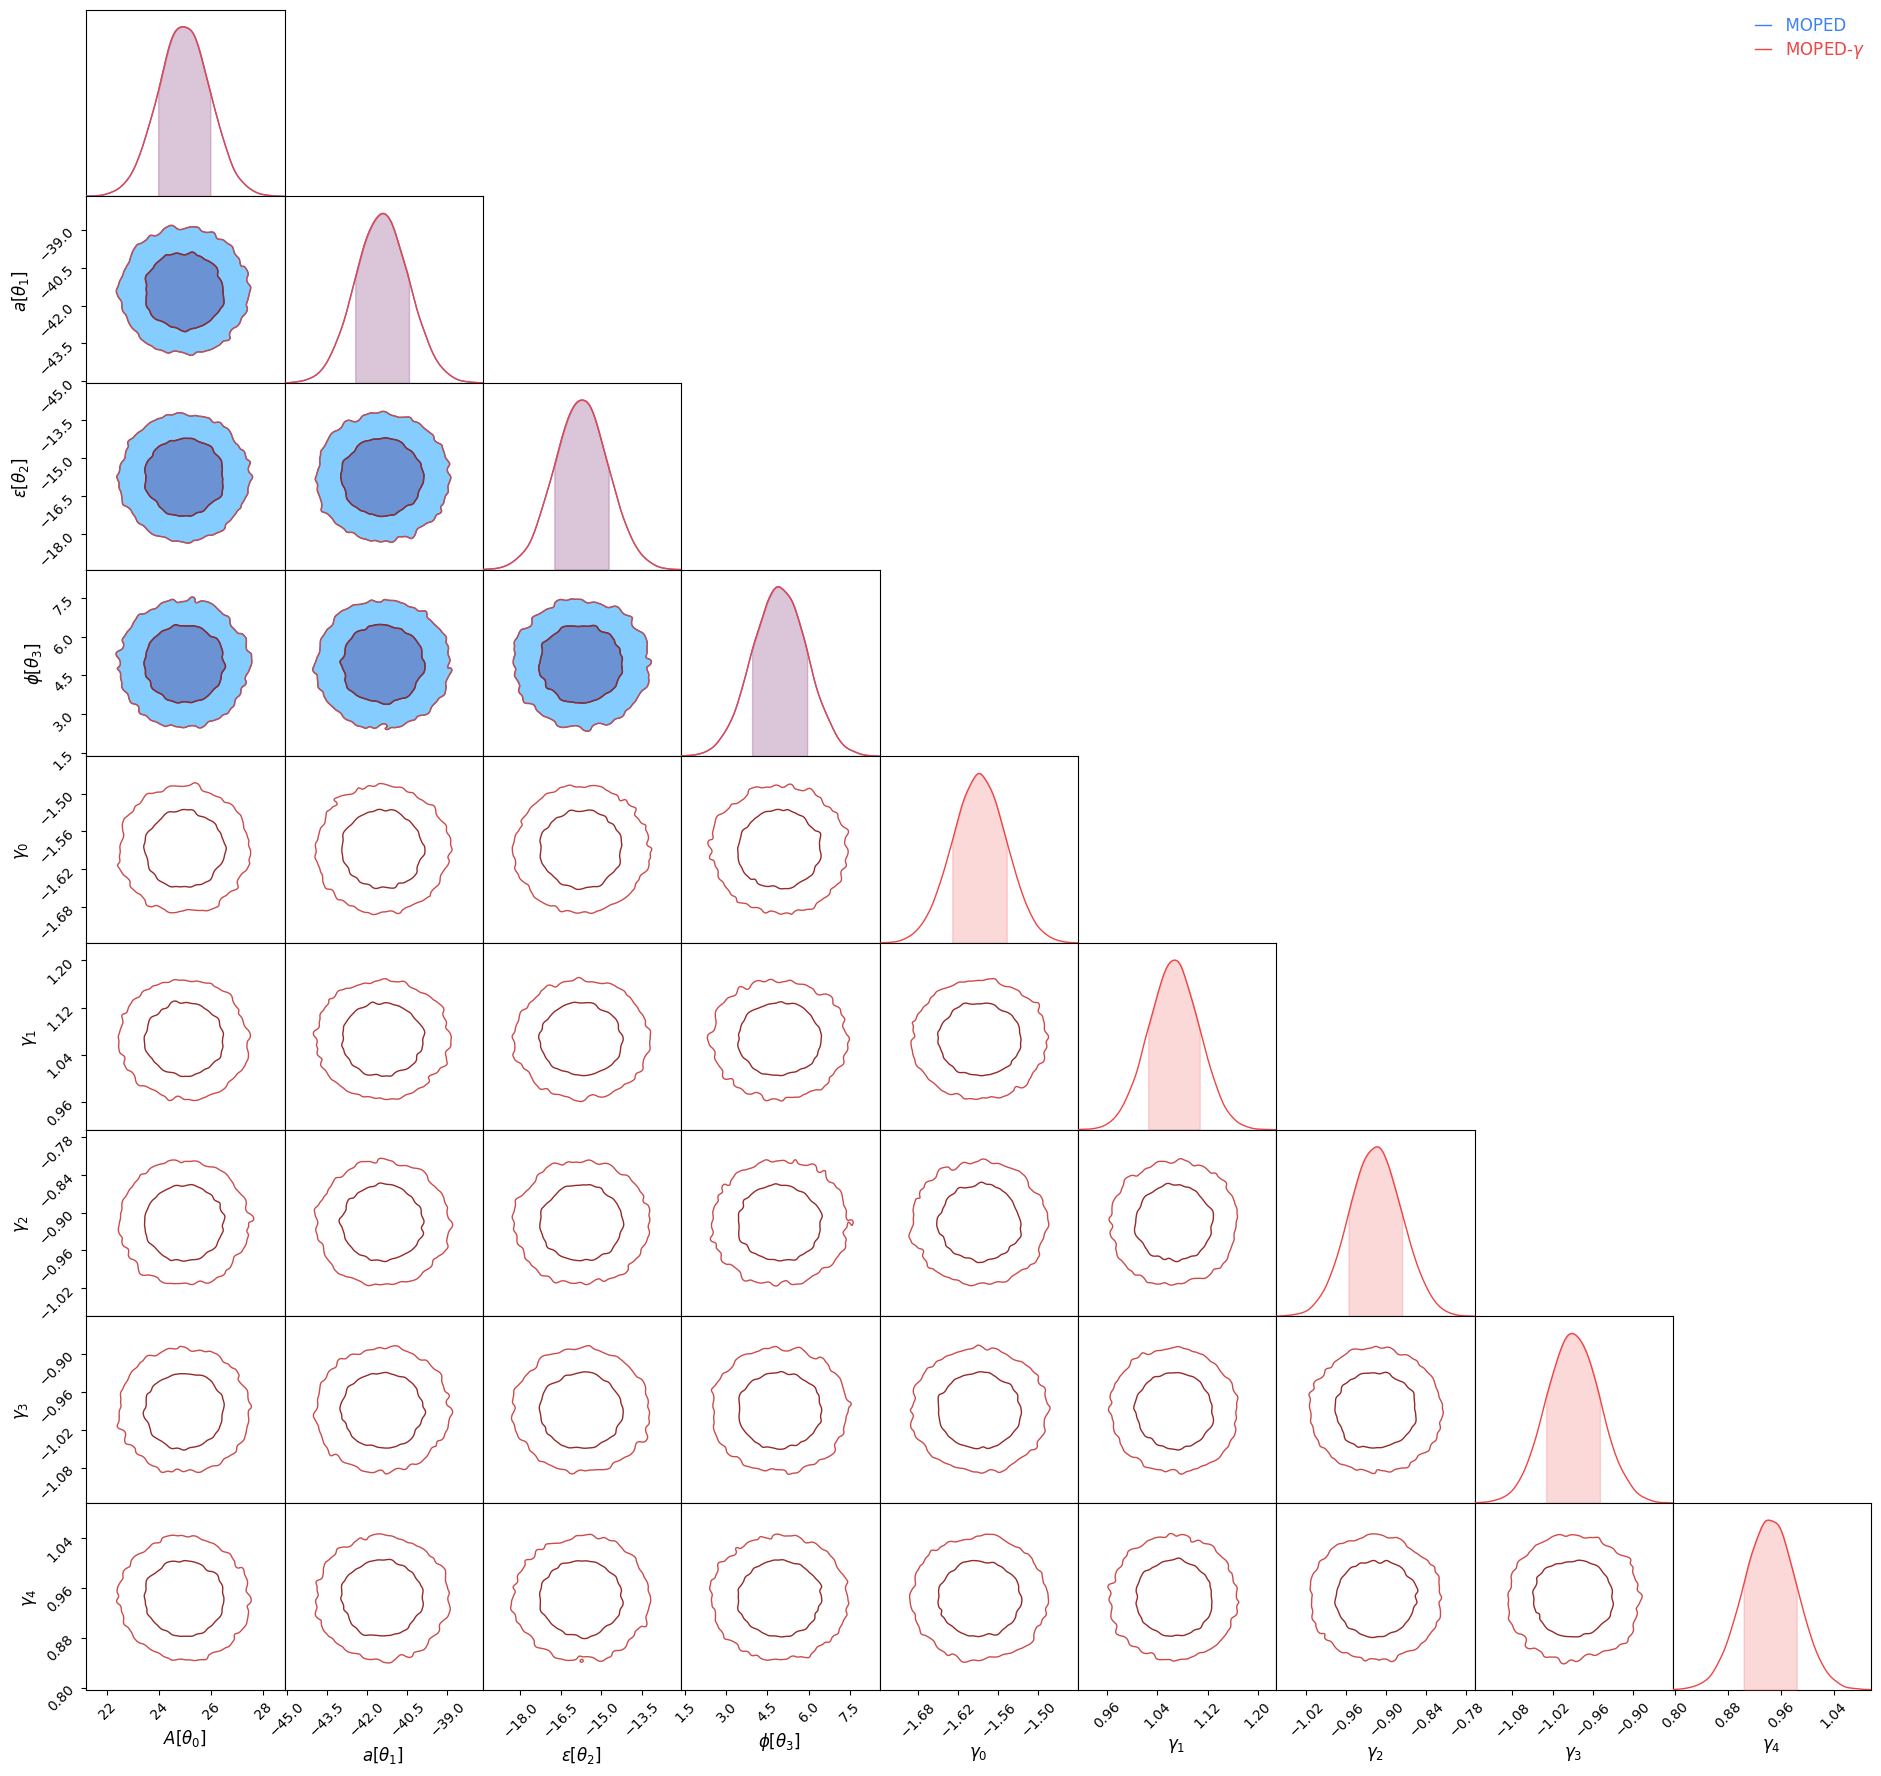

In [11]:
from chainconsumer import Chain, ChainConsumer, Truth
import pandas as pd

parameter_strings_theta = [r"{}[$\theta_{}$]".format(parameter_strings[m], m) for m in range(n_theta)]
parameter_strings_gamma = [r"$\gamma_{}$".format(n) for n in range(n_gamma)]

def make_df(y, parameter_strings, log_probs=None):
    log_posterior = np.ones((len(y),)) if log_probs is None else log_probs
    df = pd.DataFrame(
        np.asarray(y), columns=parameter_strings
    ).assign(log_posterior=log_posterior)
    return df

c = ChainConsumer()
c.add_chain(
    Chain(
        samples=make_df(y_moped_extended[:, :n_theta], parameter_strings_theta), 
        name="MOPED", shade=True, color="blue"
    )
)
c.add_chain(
    Chain(
        samples=make_df(y_moped_extended, parameter_strings_theta + parameter_strings_gamma), 
        name=r"MOPED-$\gamma$", shade=False, color="red"
    )
)
fig = c.plotter.plot()

#### Likelihood

If the original data are Gaussian distributed then the compressed statistics are Gaussian since the statistics are built with linear combinations of the data. With a Gaussian prior $p(\Theta,\Gamma)$ the posterior probability as a function of $\Gamma_\gamma$ is given by 

$$
p(\Gamma, \Theta|\mathbf{Y}) \propto p(\mathbf{Y}|\Theta, \Gamma)\pi(\Theta, \Gamma),
$$

where the likelihood is Gaussian in both $\mathbf{Y}$ and $\Gamma$

$$
p(\mathbf{Y}|\Theta, \Gamma) = (2\pi)^{-N/2}\exp\bigg[ -\frac{1}{2}\sum_{\beta=1}^N ( Y_\beta - \mathbf{f}_\beta^T[\boldsymbol{\mu}(\Theta, \Gamma) - \boldsymbol{\mu}_F] )^2 \bigg],
$$

where $\boldsymbol{\mu}(\Theta, \Gamma)$ is linear in $\Gamma_\gamma$ as given above.

The maximum likelihood point is at $(\Theta^{ML}, \Gamma^{ML})$ where $\Gamma^{ML}$ can be calculated analytically for a given $\Theta^{ML}$ since $\mathbf{f}$ and $\mathbf{u}$ are orthogonal

$$
\Gamma^{ML}_\gamma = Y_\gamma - \mathbf{f}_\gamma[\boldsymbol{\mu}(\Theta_{ML}) - \boldsymbol{\mu}_F], \; \; \gamma \in [M+1,N].
$$

If the prior on $\Gamma_\gamma$ is uniform the peak of the posterior is given by this equation. Only trivial computations are required, once a MOPED analysis is implemented, to infer $\Gamma_\gamma$.

#### Hessian  

The likelihood of $\Gamma_\gamma$ is Gaussian with the mean given by $\Gamma^{ML}_\gamma$. The covariance is given by the Hessian matrix which is of a simple form due to the orthonormality of the filters $\mathbf{f}_\alpha$.

$$
    -\frac{\partial^2\log\mathcal{L}}{\partial \Theta_\alpha \partial \Theta_\beta} = \sum_{\rho=1}^N (\mathbf{f}_\rho^T\boldsymbol{\mu}_{,\alpha})(\mathbf{f}_\rho^T\boldsymbol{\mu}_{,\beta}), \; \;
    -\frac{\partial^2\log\mathcal{L}}{\partial \Gamma_\gamma \partial \Gamma_\rho} = \delta_{\gamma\rho}, \; \;
    -\frac{\partial^2\log\mathcal{L}}{\partial \Theta_\alpha \partial \Gamma_\gamma} = \mathbf{f}^T_\gamma \boldsymbol{\mu}_{,\alpha}.
$$

Where the off-diagonal elements are zero if the ML point is the fiducial model or the baseline model is linear in the parameters.

If compressing at maximum likelihood point in fiducial model the off-diagonal terms of the Hessian matrix are zero. This requires the model to be linear in its parameters though. If not yet at this point for the fiducial, simply iterate the $\theta^{ML}$ point. 

#### Posterior

Given these conditions the posterior is given by the MOPED posterior plus factors for the independent extended modes 
$$
p(\Theta, \Gamma|\mathbf{x}) = p(\Theta|\mathbf{y})\prod_{\gamma=M+1}^N \mathcal{G}[\Gamma_\gamma|\Gamma^{ML}_\gamma, 1],
$$
where $\boldsymbol{y}$ are the default MOPED statistics, this means that the introduced parameters $\Gamma$ do not degrade the precision of the estimates of $\Theta$.

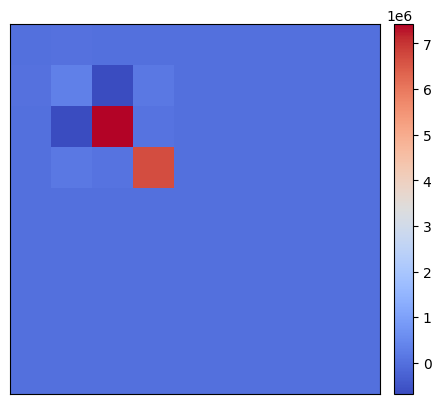

In [12]:
# Construct Hessian

from scipy.linalg import block_diag

H = np.zeros((n_theta, n_theta))

# MOPED theta modes
for i in range(n_theta):
    for j in range(n_theta):
        H[i, j] = sum(
            (U_extended[p, :] @ dmu[i, :]) * (U_extended[p, :] @ dmu[j, :])
            for p in range(min(n_theta + n_gamma, n_d))
        )

# Extended-MOPED gamma modes
H_extended = jnp.eye(n_gamma)

H = block_diag(H, H_extended)

# Off-diagonal theta-gamma blocks
for i in range(n_theta + n_gamma):
    for j in range(n_theta + n_gamma):
        if i > n_theta or j > n_theta:
            H[i, j] = U_extended[i, :] @ dmu[j, :]

H = jnp.asarray(H)

plt.figure()
im = plt.imshow(H)
plt.colorbar(im, fraction=0.05, pad=0.03)
plt.xticks([])
plt.yticks([])
plt.show()

In [13]:
def prior_theta(theta):
    # lower = jnp.array([1e-2, 0.1, 0.0, 0.0])
    # upper = jnp.array([1e2, 30.0, 0.95, jnp.pi]) 
    # return jnp.sum(jss.uniform.logpdf(theta, lower, lower + upper))
    return jnp.sum(jss.multivariate_normal.logpdf(theta, jnp.zeros_like(theta), 5.0 * jnp.eye(n_theta)))

def prior_gamma(gamma):
    # lower = jnp.array([1e-2, 0.1])
    # upper = jnp.array([1e2, 30.0])
    # return jnp.sum(jss.uniform.logpdf(gamma, lower, lower + upper))
    return jnp.sum(jss.multivariate_normal.logpdf(gamma, jnp.zeros_like(gamma), 5.0 * jnp.eye(gamma.size)))

In [14]:
datavector = simulator(key) # Datavector from baseline model

datavector_extended = simulator_extended(key) # Datavector from baseline model

In [15]:
# Likelihood analysis on uncompressed data with baseline model

def likelihood(d, theta):
    mu_theta = baseline_model(theta)
    L = jss.multivariate_normal.logpdf(d, mean=mu_theta, cov=covariance) 
    return L + prior_theta(theta)

def log_prob_fn(params, d):
    return likelihood(d, params) 

initial_state = theta[jnp.newaxis, :] # n_chains 
samples, samples_log_prob = nuts_sample(
    key, 
    log_prob_fn=partial(log_prob_fn, d=datavector),
    n_samples=100_000,
    n_warmup_steps=1000,
    initial_state=initial_state
)

df_full = make_df(samples, parameter_strings_theta, log_probs=samples_log_prob)

In [16]:
# Likelihood analysis on MOPED compressed data with baseline model
cov_y = jnp.linalg.multi_dot([U, covariance, U.T])

def likelihood(d, theta):
    mu_theta = baseline_model(theta)
    y_theta = moped(mu_theta)
    y = moped(d)
    L = jss.multivariate_normal.logpdf(y, mean=y_theta, cov=cov_y)
    return L + prior_theta(theta) 

def log_prob_fn(params, d):
    return likelihood(d, params) 

initial_state = theta[jnp.newaxis, :] # n_chains 
samples, samples_log_prob = nuts_sample(
    key, 
    log_prob_fn=partial(log_prob_fn, d=datavector),
    n_samples=100_000,
    n_warmup_steps=1000,
    initial_state=initial_state
)

df_moped = make_df(samples, parameter_strings_theta, log_probs=samples_log_prob)

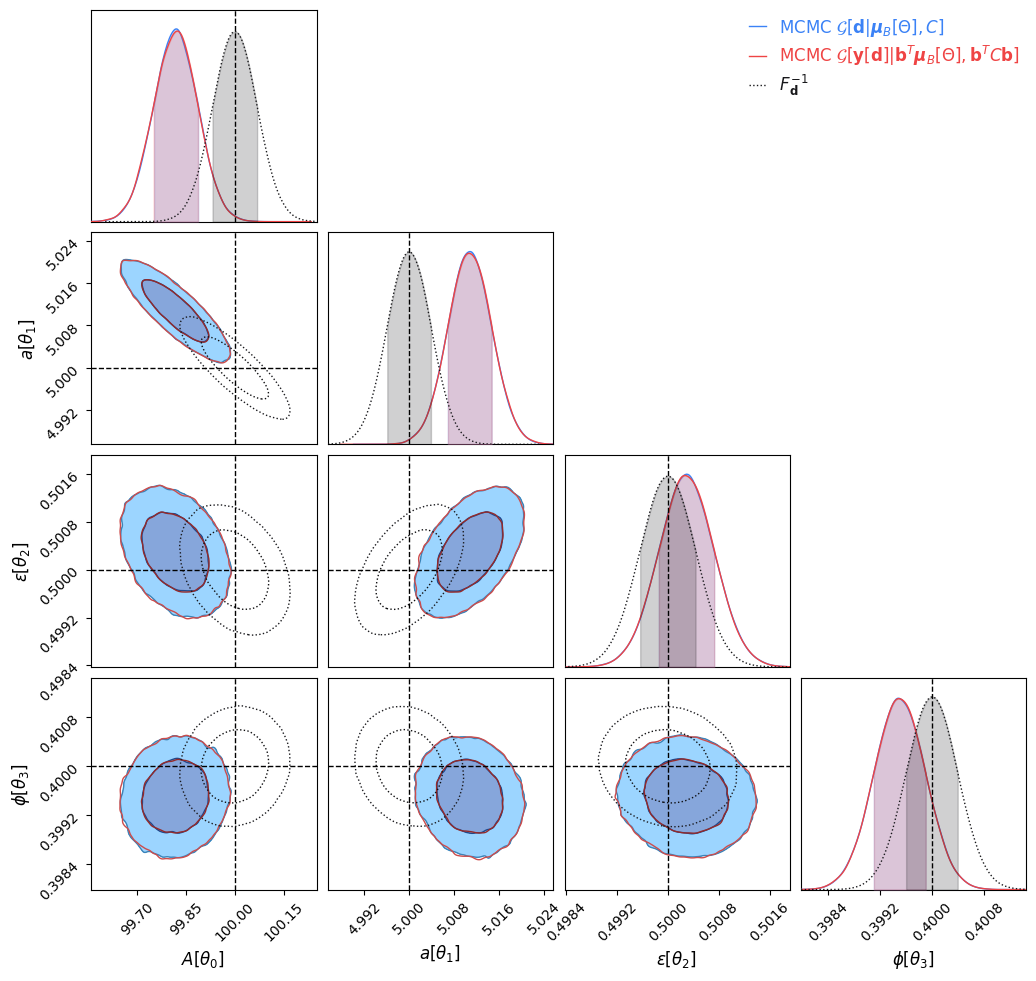

In [17]:
c = ChainConsumer()
c.add_chain(
    Chain(
        samples=df_full, 
        name=r"MCMC $\mathcal{G}[\mathbf{d}|\boldsymbol{\mu}_B[\Theta], C]$", 
        shade=True, 
        color="blue"
    )
)
c.add_chain(
    Chain(
        samples=df_moped, 
        name=r"MCMC $\mathcal{G}[\mathbf{y}[\mathbf{d}]|\mathbf{b}^T\boldsymbol{\mu}_B[\Theta], \mathbf{b}^T C \mathbf{b}]$", 
        shade=False, 
        color="red"
    )
)
c.add_chain(
    Chain.from_covariance(
        theta,
        Finv_d,
        columns=parameter_strings_theta,
        name=r"$F^{-1}_\mathbf{d}$",
        color="k",
        shade=False,
        linestyle=":",
    )
)
c.add_truth(
    Truth(
        location=dict(zip(parameter_strings_theta, np.asarray(theta))),
        color="k"
    )
)
fig = c.plotter.plot()

In [18]:
# Likelihood analysis on extended-MOPED compressed data with extended model (data from baseline model)

# For linear gamma model, skip MOPED filters
u_gammas = U_extended[n_theta:n_theta + n_gamma, :] 

# MOPED statistics are orthogonal, unit variance; same with extended statistics
# cov_f = jnp.eye(n_theta + n_gamma) 
cov_f = jnp.asarray(block_diag(cov_y, jnp.eye(n_gamma)))

def likelihood(d, theta, gamma):
    mu_theta = baseline_model(theta)
    y = moped_extended(d)
    # Model at extended parameters
    mu_gamma = sum(_gamma * (covariance @ u_gammas[i, :]) for i, _gamma in enumerate(gamma))
    mu_theta_gamma = mu_theta + mu_gamma 
    # Mean of extended-MOPED likelihood
    f_theta_gamma = moped_extended(mu_theta_gamma) # NOTE: compare to Equation 19
    # Covariance of likelihood for MOPED + extended statistics
    L = jss.multivariate_normal.logpdf(y, mean=f_theta_gamma, cov=cov_f) # NOTE: correct covariance?
    return L 

def log_prob_fn(params, d):
    theta, gamma = jnp.split(params, [n_theta])
    return likelihood(d, theta, gamma) + prior_theta(theta) + prior_gamma(gamma)

initial_state = jnp.concatenate([theta[jnp.newaxis, :], jnp.zeros((1, n_gamma))], axis=1)
samples, samples_log_prob = nuts_sample(
    key, 
    log_prob_fn=partial(log_prob_fn, d=datavector),
    n_samples=100_000,
    n_warmup_steps=1000,
    initial_state=initial_state
)

df_extended_moped = make_df(samples, parameter_strings_theta + parameter_strings_gamma, log_probs=samples_log_prob)

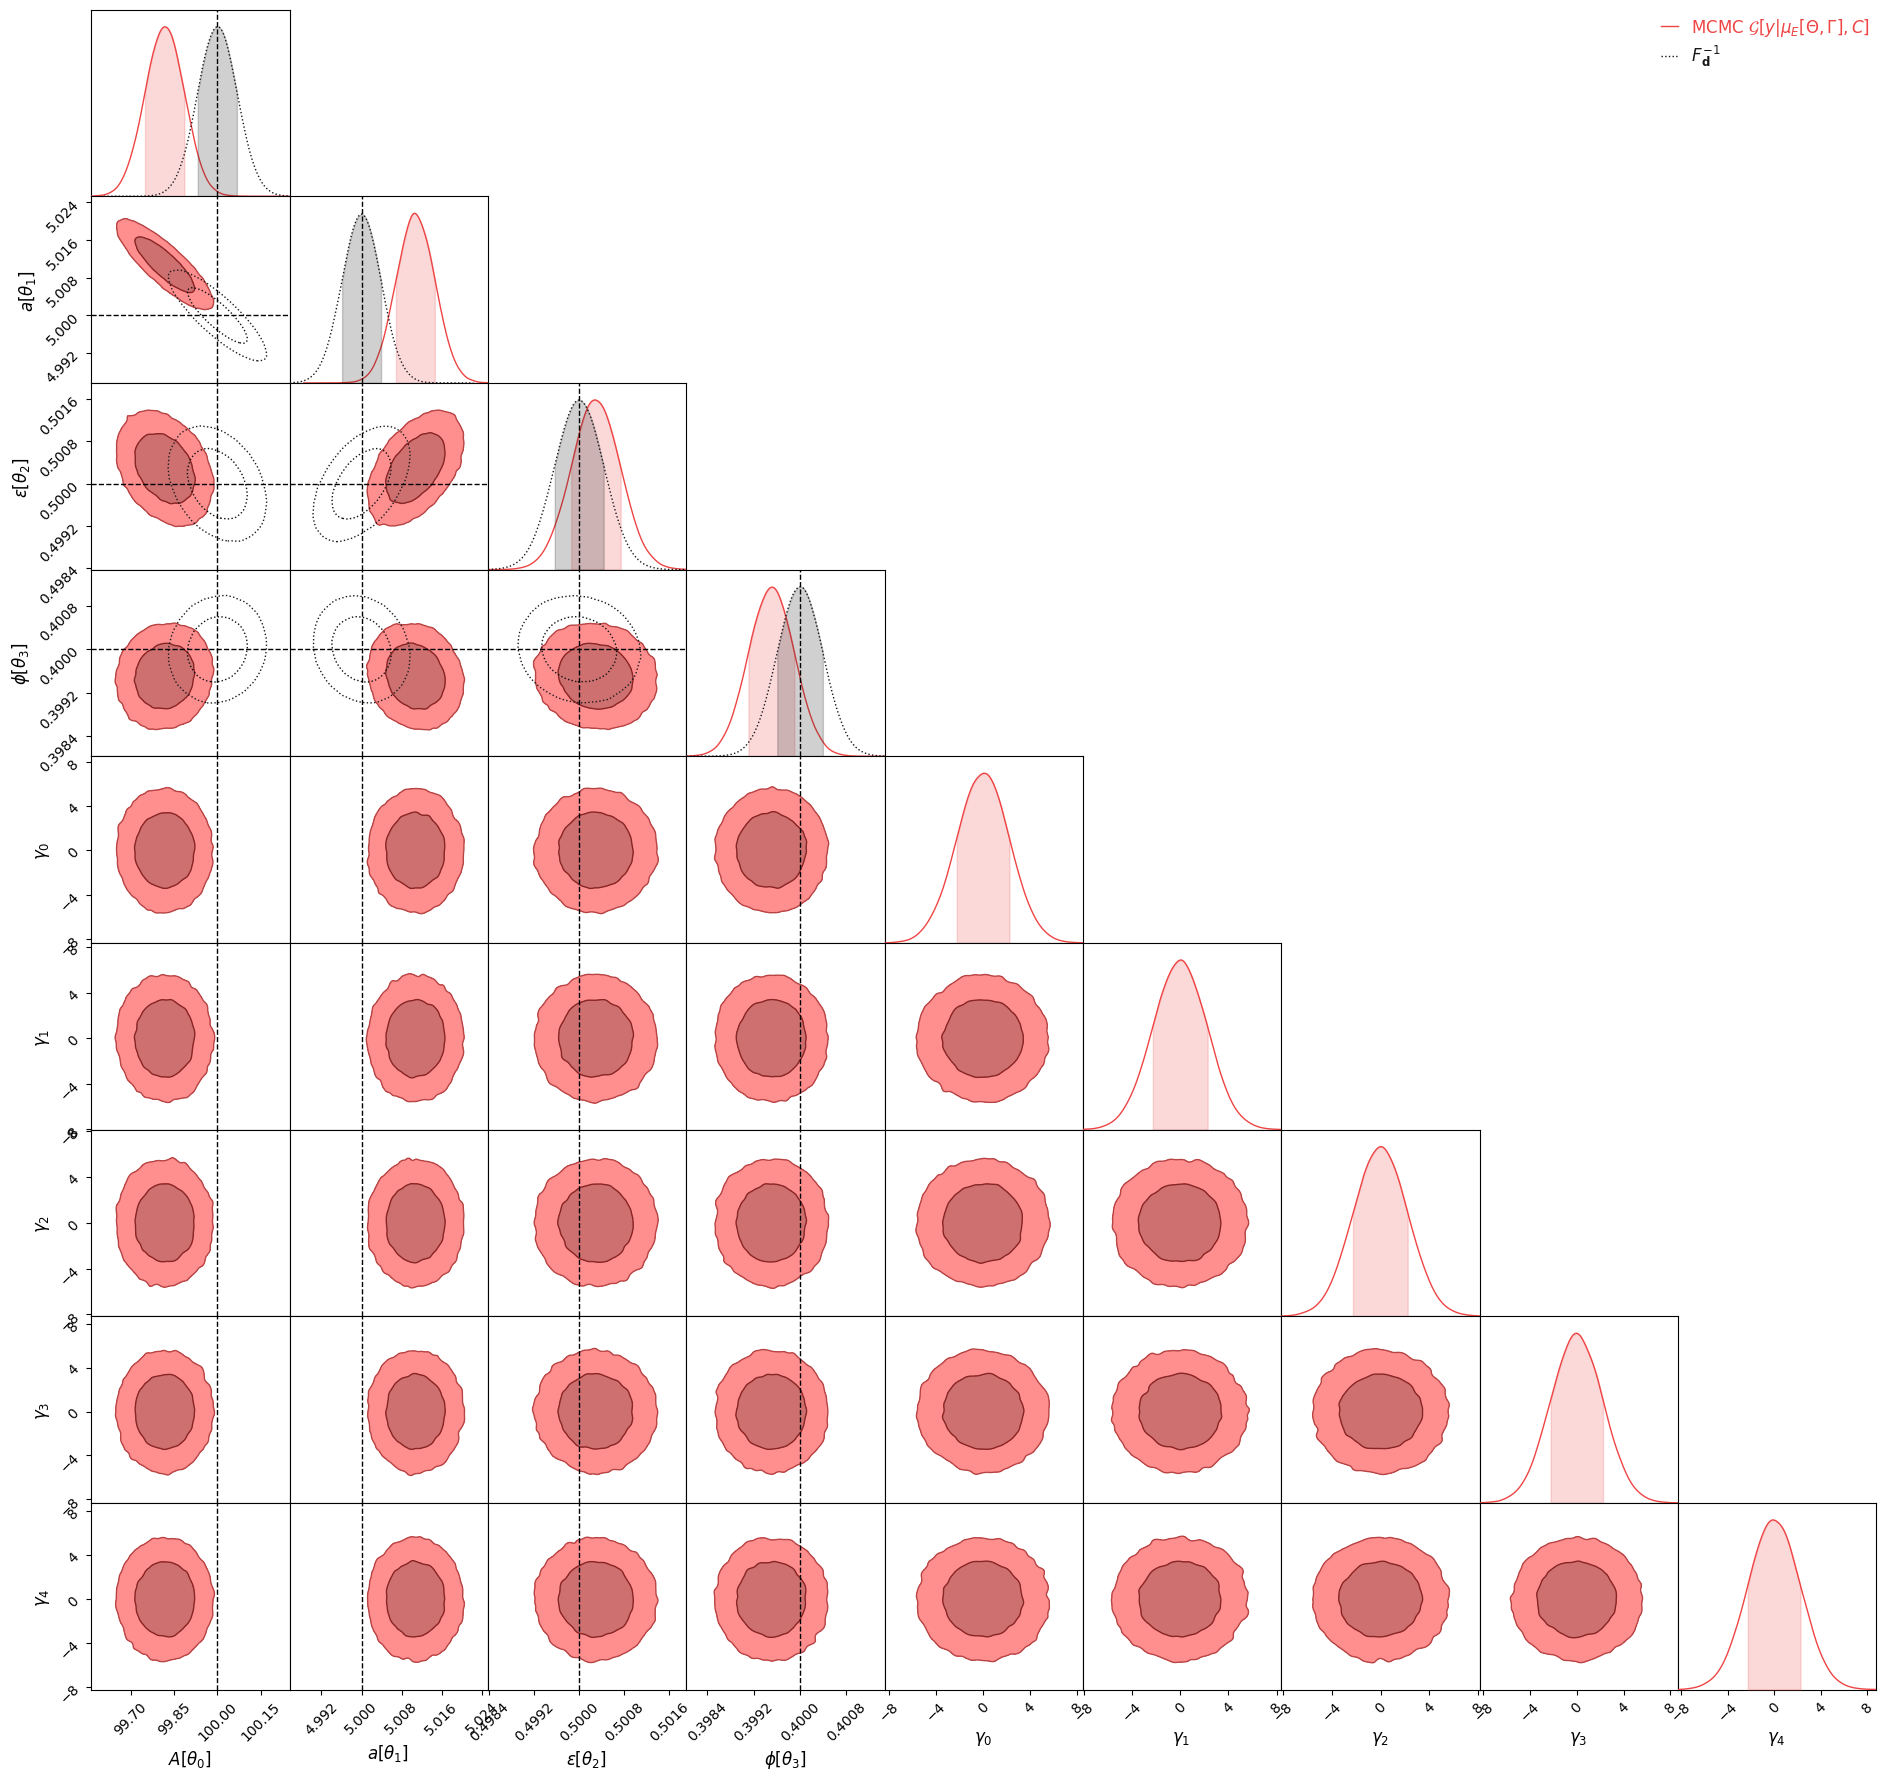

In [19]:
c = ChainConsumer()
c.add_chain(
    Chain(
        samples=df_extended_moped, 
        name=r"MCMC $\mathcal{G}[y|\mu_E[\Theta, \Gamma], C]$", 
        shade=True, 
        color="red"
    )
)
c.add_chain(
    Chain.from_covariance(
        theta,
        Finv_d,
        columns=parameter_strings_theta,
        name=r"$F^{-1}_\mathbf{d}$",
        color="k",
        shade=False,
        linestyle=":"
    )
)
c.add_truth(
    Truth(
        location=dict(zip(parameter_strings_theta, np.asarray(theta))),
        color="k"
    )
)
fig = c.plotter.plot()

In [ ]:
# Likelihood analysis on extended-MOPED compressed data with extended model (data from extended model)

def likelihood(d, theta, gamma):
    mean_theta = baseline_model(theta)
    y = moped_extended(d)
    # For linear gamma model, skip MOPED filters
    u_gammas = U_extended[n_theta:n_theta + n_gamma, :] # Skip MOPED filters
    # Model at extended parameters
    mean_gamma = sum(_gamma * (covariance @ u_gammas[i, :]) for i, _gamma in enumerate(gamma))
    mean_theta_gamma = mean_theta + mean_gamma
    # Mean of extended-MOPED likelihood
    mean_theta_gamma = moped_extended(mean_theta_gamma)
    # Covariance of likelihood for MOPED + extended statistics
    L = jss.multivariate_normal.logpdf(y, mean=mean_theta_gamma, cov=cov_f) # NOTE: correct covariance?
    return L 

def log_prob_fn(params, d):
    theta, gamma = jnp.split(params, [n_theta])
    return likelihood(d, theta, gamma) + prior_theta(theta) + prior_gamma(gamma)

initial_state = jnp.concatenate([theta[jnp.newaxis, :], jnp.zeros((1, n_gamma))], axis=1)
samples, samples_log_prob = nuts_sample(
    key, 
    log_prob_fn=partial(log_prob_fn, d=datavector_extended),
    n_samples=100_000,
    n_warmup_steps=1000,
    initial_state=initial_state
)

df_extended_moped = make_df(
    samples, parameter_strings_theta + parameter_strings_gamma, log_probs=samples_log_prob
)

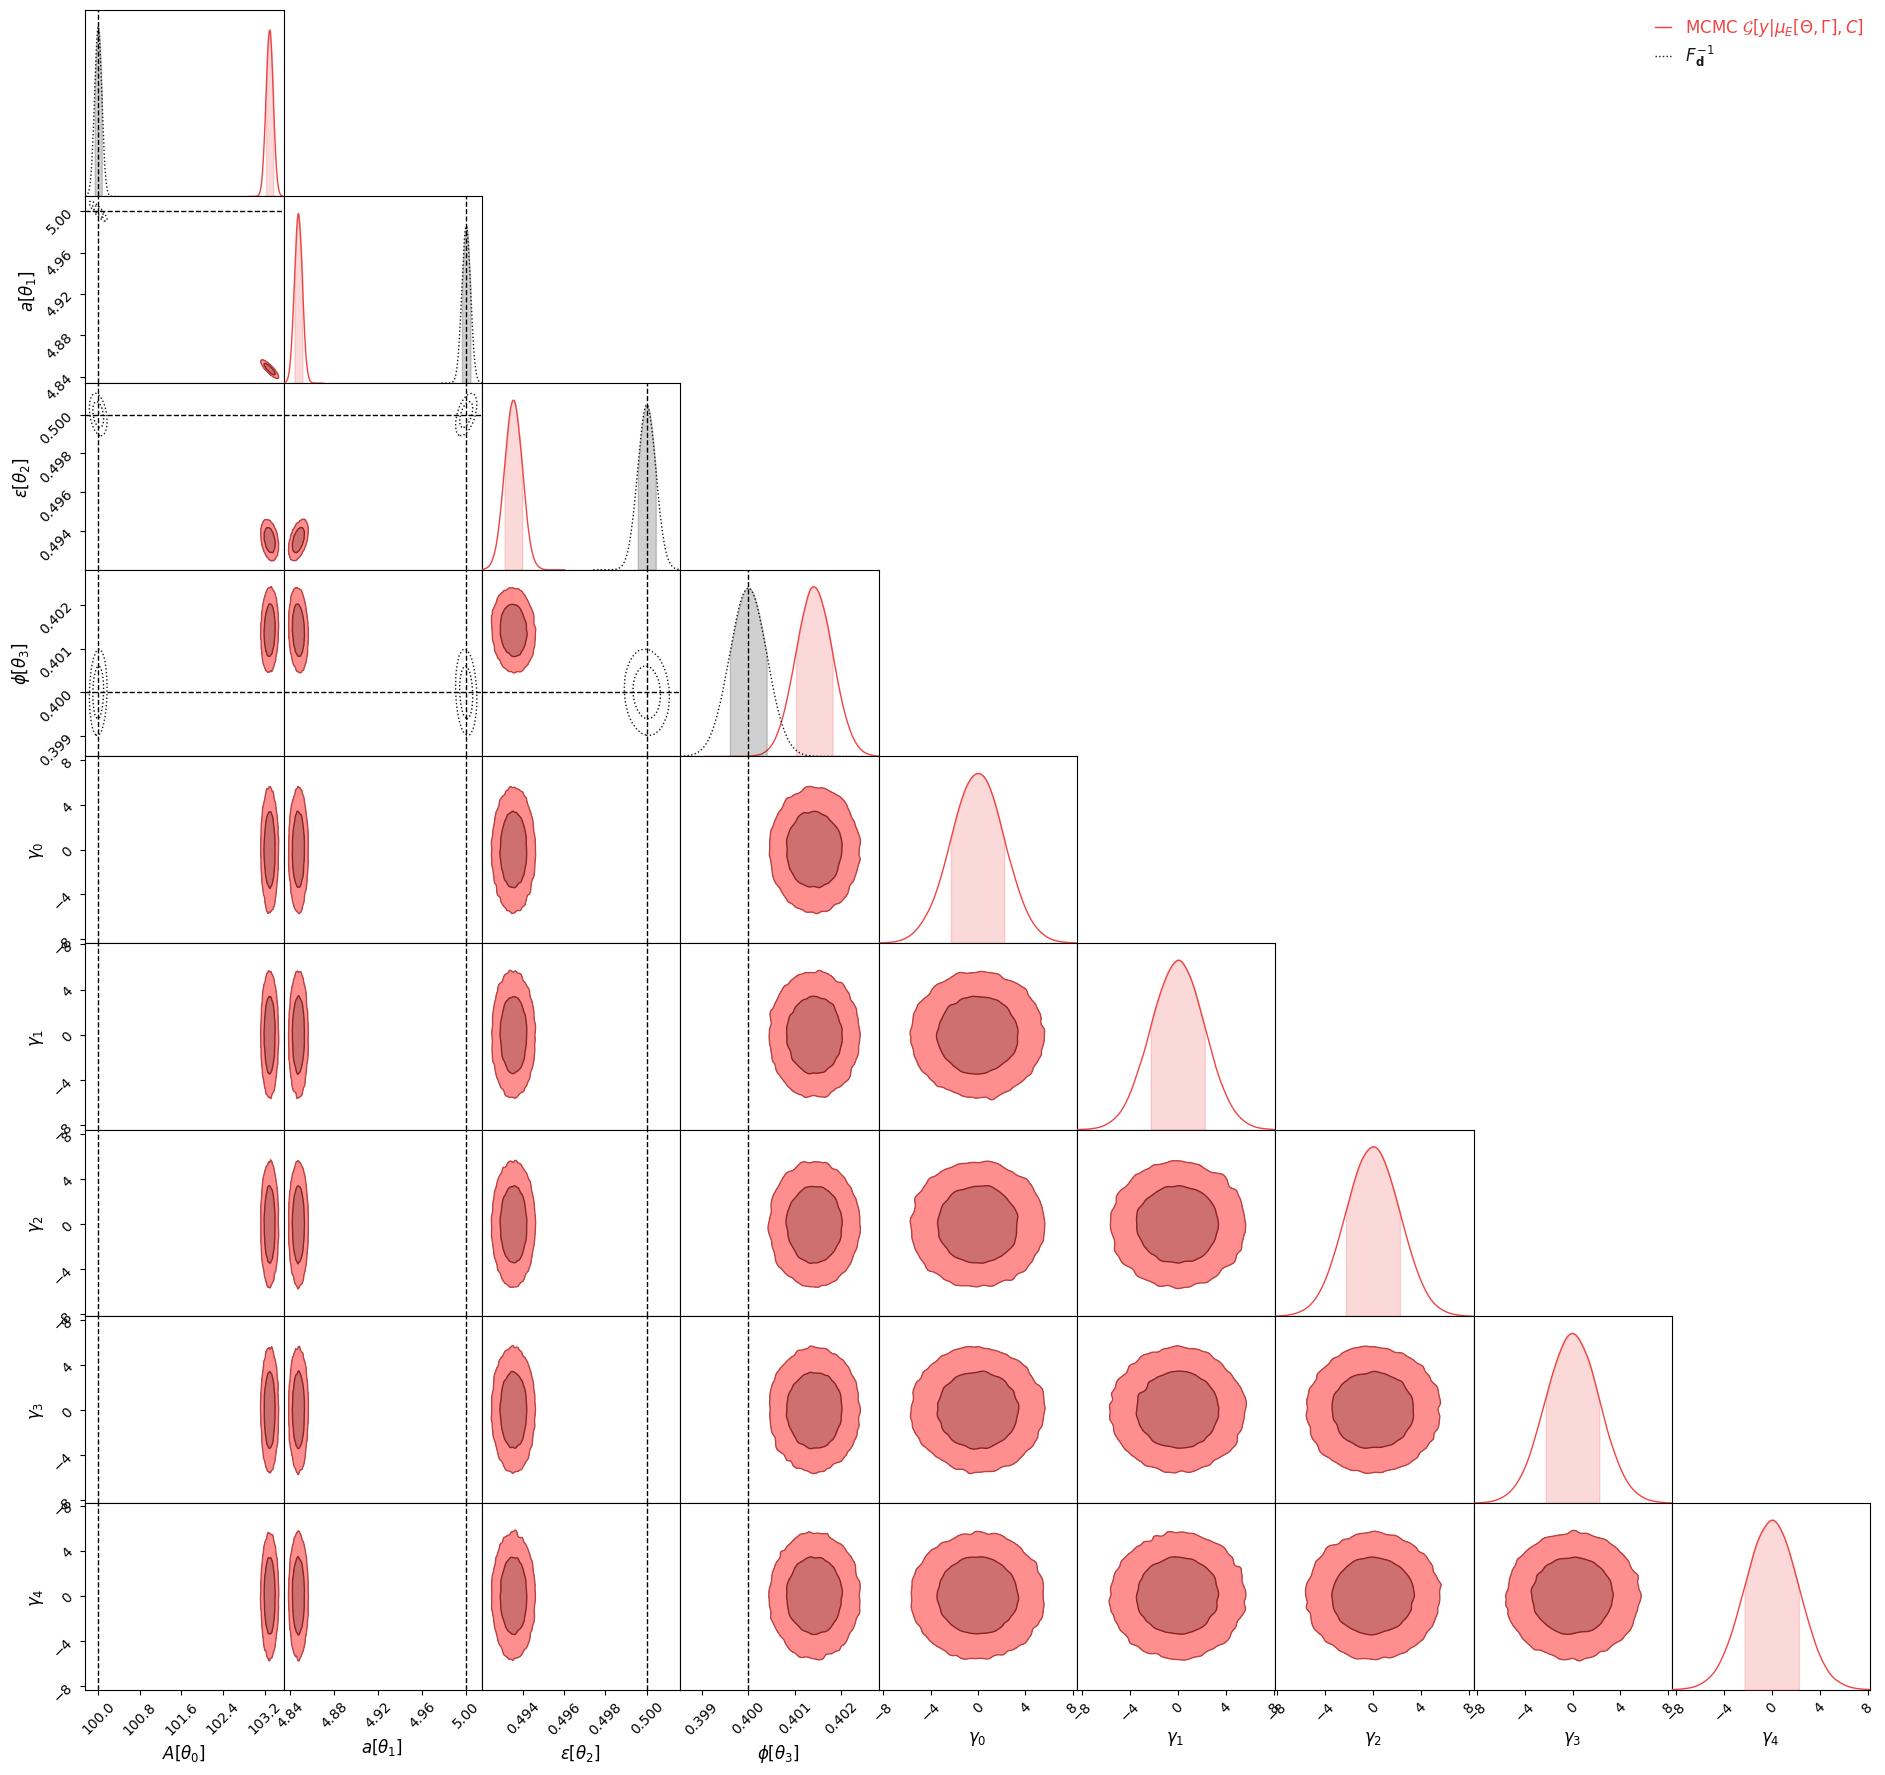

In [21]:
c = ChainConsumer()
c.add_chain(
    Chain(
        samples=df_extended_moped, 
        name=r"MCMC $\mathcal{G}[y|\mu_E[\Theta, \Gamma], C]$", 
        shade=True, 
        color="red"
    )
)
c.add_chain(
    Chain.from_covariance(
        theta,
        Finv_d,
        columns=parameter_strings_theta,
        name=r"$F^{-1}_\mathbf{d}$",
        color="k",
        shade=False,
        linestyle=":"
    )
)
c.add_truth(
    Truth(
        location=dict(zip(parameter_strings_theta, np.asarray(theta))),
        color="k"
    )
)
fig = c.plotter.plot()